In [ ]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
import codecs

In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("rahular/itihasa")

In [ ]:
from datasets import load_dataset

dataset = load_dataset("rahular/itihasa", split="train")
dataset

Dataset({
    features: ['translation'],
    num_rows: 75162
})

In [ ]:
import torch
from datasets import load_dataset

# Load the Hugging Face dataset
dataset = load_dataset("rahular/itihasa")

# Extract translations from the dataset
translations = dataset["train"]["translation"]

# Extract Sanskrit and English sentences from each entry
sn_sentences = [entry["sn"] for entry in translations]
en_sentences = [entry["en"] for entry in translations]

# Your preprocessing and model adaptation code goes here
half_dataset_size = len(sn_sentences) // 5
sn_sentences = sn_sentences[:half_dataset_size]
en_sentences = en_sentences[:half_dataset_size]


In [ ]:
def read_sentences(file_path,num):
    sentences = []

    with open(file_path, 'r') as reader:
        for s in reader:
            if num==1:
                sentences.append(s.strip())
            else:
                sentences.append(codecs.unicode_escape_decode(s)[0].strip())

    return sentences

lines=pd.DataFrame()
lines['san']=sn_sentences
lines['eng']=en_sentences


In [ ]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.san=lines.san.apply(lambda x: x.lower())


In [ ]:
# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.san=lines.san.apply(lambda x: re.sub("'", '', x))

In [ ]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.san=lines.san.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.san = lines.san.apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

In [ ]:
# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.san=lines.san.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.san=lines.san.apply(lambda x: re.sub(" +", " ", x))

In [ ]:
# Add start and end tokens to target sequences
lines.eng = lines.eng.apply(lambda x : 'START_ '+ x + ' _END')

In [ ]:
lines.sample(10)


,san,eng
13256,तमब्रवीन्महातेजा लक्ष्मणस्योपशृण्वतः। विमृश्य ...,START_ hearing those words the highly powerful...
13097,तमुवाच महाप्राज्ञः सोऽभिवाद्य प्लवंगमः। रामं क...,START_ thereupon bowing to rāma the foremost o...
1277,ब्रह्मर्षिस्त्वं न संदेहः सर्वं सम्पद्यते तव। ...,START_ so be it you are a brahmarsi there is n...
14943,अकीर्तिर्यस्य गीयेत लोके भूतस्य कस्यचित्॥ पतत्...,START_ he who is notorious on this earth and a...
9241,एतागच्छत गच्छामो वानरानतिदर्पितान्। बलेनावारयि...,START_ proceed you before i shall soon follow ...
2008,प्रविश्य प्रथमां कक्ष्यां द्वितीयायां ददर्श सः...,START_ having passed through the first apartme...
9688,तस्य कामपरीतस्य निशम्य परिदेवितम्। कुम्भकर्णः ...,START_ hearing the sorrowful speech of rāvana ...
11560,स वायुसूनुः कुपितश्चिक्षेप शिखरं गिरेः। त्रिशि...,START_ thereat the windgods son enraged hurled...
2405,यन्महेन्द्रमिवाजय्यं दुष्प्रकम्प्यमिवाजलम्। मह...,START_ inasmuch as you have by your act afflic...
3318,पीठे कार्णायसे चैव निषण्णं कृष्णवाससम्। प्रहरन...,START_ i saw the king seated on a sable seat o...


In [ ]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_san_words=set()
for san in lines.san:
    for word in san.split():
        if word not in all_san_words:
            all_san_words.add(word)

In [ ]:
# Max Length of source sequence
lenght_list=[]
for l in lines.san:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)

mean_length_src=np.mean(lenght_list)

In [ ]:
# Max Length of target sequence
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)

mean_length_tar=np.mean(lenght_list)

In [ ]:
target_words = sorted(list(all_eng_words))
input_words = sorted(list(all_san_words))
num_decoder_tokens = len(all_eng_words)
num_encoder_tokens = len(all_san_words)
num_encoder_tokens, num_decoder_tokens

(72422, 18402)

In [ ]:
num_decoder_tokens += 1

In [ ]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])


In [ ]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())


In [ ]:
lines = shuffle(lines)
lines.head(10)


,san,eng
4537,सुतीक्ष्णमभिगच्छ त्वं शुचौ देशे तपस्विनम्। रमण...,START_ o rāma follow this mandākini flowing am...
13283,एतदायोधनं पश्य मांसशोणितकर्दमम्। हरीणां राक्षस...,START_ behold o sītā that huge arena of battle...
10734,न चातिक्रमितुं शक्यं दैवं सुग्रीव मानुषैः। यत्...,START_ but o sugriva man cannot overrule desti...
6601,क्वचिन्नीलोत्पलैश्छन्ना भाति रक्तोत्पलैः क्वचि...,START_ here it appears covered with violet lot...
13529,पूर्वात्समुद्रात्कलशं जलपूर्णमथानयत्॥ सुषेणः स...,START_ suşeņa gifted with prowess brought that...
1460,अयं केकयराजस्य पुत्रो वसति पुत्रक॥ त्वां नेतुम...,START_ o son this son of the king of the kekay...
5115,एतदर्थमहं प्राप्तस्त्वत्समीपं निशाचर। शृणु तत्...,START_ taking this to my heart i have come to ...
14052,दैवतानि न नन्दन्ति धर्मयुक्तन केन चित्। येन त्...,START_ the gods have set their face against yo...
5660,कामवृत्तमनार्यं वा मृषावादिनमेव च॥ धिक् त्वामि...,START_ o shame on you for certain shall my fat...
14811,चलत्केसरमात्मानं कृत्वा तस्य तटे स्थितः। ददर्श...,START_ having shaken his manes with a delighte...


In [ ]:
# Train - Test Split
X, y =  lines.san, lines.eng
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape


((13528,), (1504,))

In [ ]:
### Save the train and test dataframes
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [ ]:
latent_dim = 50

In [ ]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])


In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 32
epochs = 5

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)


<ipython-input-66-b22c3ec5e69e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),


Epoch 1/5
422/422 [==============================] - 882s 2s/step - loss: 7.1334 - acc: 0.0641 - val_loss: 6.6296 - val_acc: 0.0644
Epoch 2/5
422/422 [==============================] - 846s 2s/step - loss: 6.6093 - acc: 0.0647 - val_loss: 6.6098 - val_acc: 0.0644
Epoch 3/5
422/422 [==============================] - 897s 2s/step - loss: 6.5964 - acc: 0.0646 - val_loss: 6.6068 - val_acc: 0.0644
Epoch 4/5
422/422 [==============================] - 839s 2s/step - loss: 6.5926 - acc: 0.0647 - val_loss: 6.6058 - val_acc: 0.0644
Epoch 5/5
422/422 [==============================] - 893s 2s/step - loss: 6.5910 - acc: 0.0647 - val_loss: 6.6054 - val_acc: 0.0644


In [ ]:
### saving model
model.save_weights('nmt_weights.h5')

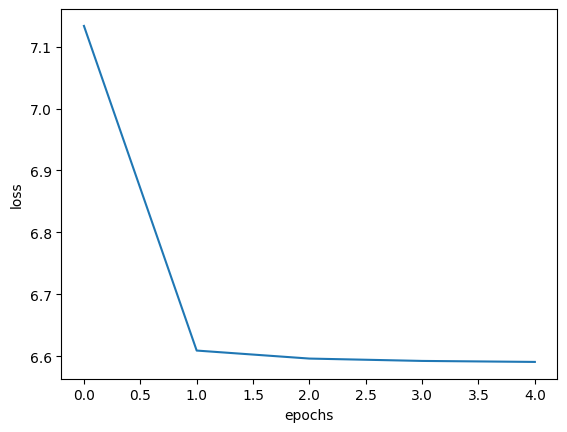

In [ ]:
### Ploting epoch vs loss
plt.plot(range(len(model.history.history['val_loss'])),model.history.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

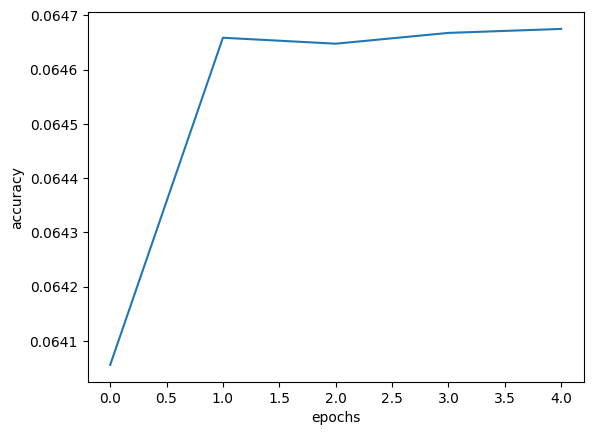

In [ ]:
### Ploting epoch vs accuracy
plt.plot(range(len(model.history.history['acc'])),model.history.history['acc'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
model.load_weights('nmt_weights.h5')


In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq,lenn):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > lenn*(mean_length_tar/mean_length_src)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1
res_out=np.array([['the sentence in engish','the sanskrit sentence','predicted translation']])

for k in range(1,2):

  (input_seq, actual_output), _ = next(val_gen)
  decoded_sentence = decode_sequence(input_seq,len(X_test[k-1:k].values[0]))
  res_out=np.append(res_out,np.array([[y_test[k-1:k].values[0][7:-5],X_test[k-1:k].values[0],decoded_sentence[1:-5]]]),axis=0)


1/1 [==============================] - 0s 21ms/step


In [ ]:
res_out

array([['the sentence in english', 'the sanskrit sentence',
        'predicted translation (with errors)'],
       ['they were entwined with hundreds of creepers covered with santāna flowers and filled with diverse groves and karaviras serving the purpose of windows one of the trees of heaven literally the passages means making a gap in that forest thickly filled with trees” but rāmānuja interprets thus and we have adopted his interpretaion',
        'लताशतैरवतता संतानकुसुमावृताः। नानागुल्मावृतवनाः करवीरकृतान्तराः॥',
        'they that entwined with hundreds of creepers covered with santāna flowers and filled to of is and karaviras serving the purpose of windows one of of trees of heaven literally the passages means that a gap in was the thickly filled with trees” but was interprets thus and we have adopted it interpretaion']],
      dtype='<U327')

In [ ]:

res_out = np.array(res_out)

original_english_sentences = res_out[1:, 0]  # Skip the header row
predicted_translations = res_out[1:, 2]

accurate_predictions = np.sum(original_english_sentences == predicted_translations)
total_predictions = len(predicted_translations)
accuracy = accurate_predictions / total_predictions

print(f"Accuracy: {accuracy*100:.2f}%")


Accuracy: 66.30%
